In [60]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['figure.dpi'] = 150

## `Maxwell Damping` in FLAC Command

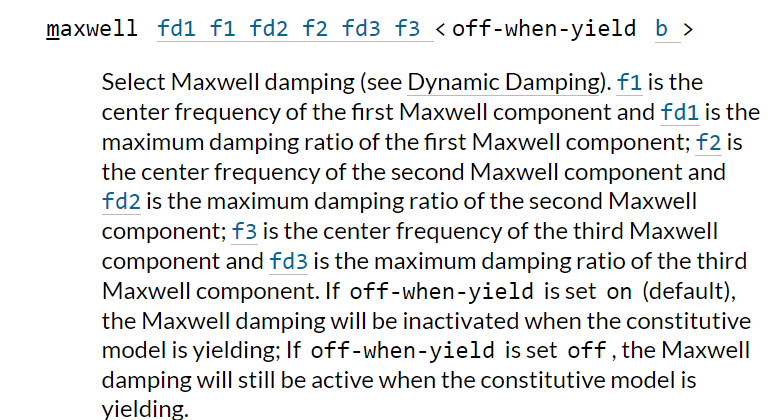

In [61]:
def get_single_maxwell_component(f_max: float, 
                                d_max: float, 
                                freq_maxwell: np.ndarray) -> np.ndarray:
    """Calculates the single frequency response from a maxwell component in a dynamic system

    Args:
        f_max (float): Frequency coresponding to the maximum damping ratio - [Hz]
        d_max (float): Maximum damping ratio. -[decimal] consistent with FLAC input
        freq_maxwell (np.ndarray): Array of frequencies for the Maxwell component. -[Hz]
    Returns:
        damping_maxwell (np.ndarray): Array of damping ratios corresponding to the frequencies. -[%]
    """
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    damping_maxwell = alpha_k * tao_k * omega_maxwell / ( 2 + 2*(1 + alpha_k) * tao_k**2 * omega_maxwell**2) * 100 # -[%]
    return damping_maxwell

def get_maxwell_real(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    return alpha_k * tao_k**2*omega_maxwell**2 / (1 + tao_k**2*omega_maxwell**2)

def get_maxwell_imag(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    return alpha_k * tao_k*omega_maxwell / (1 + tao_k**2*omega_maxwell**2)


def get_flac_maxwell(fd1: float, f1: float, 
                    fd2: float, f2: float, 
                    fd3: float, f3: float) -> np.ndarray:
    freq_band = np.logspace(-1, 2, num=200)
    
    fd_all= [fd1, fd2, fd3]
    f_all = [f1, f2, f3]
    xi_sum = np.zeros_like(freq_band)
    for freq, fd in zip(f_all, fd_all):
        xi_maxwell = get_single_maxwell_component(freq, fd, freq_band)
        xi_sum = np.sum([xi_sum, xi_maxwell], axis=0)

    damping_maxwell = xi_sum
    return damping_maxwell, freq_band

### Single Maxwell Component

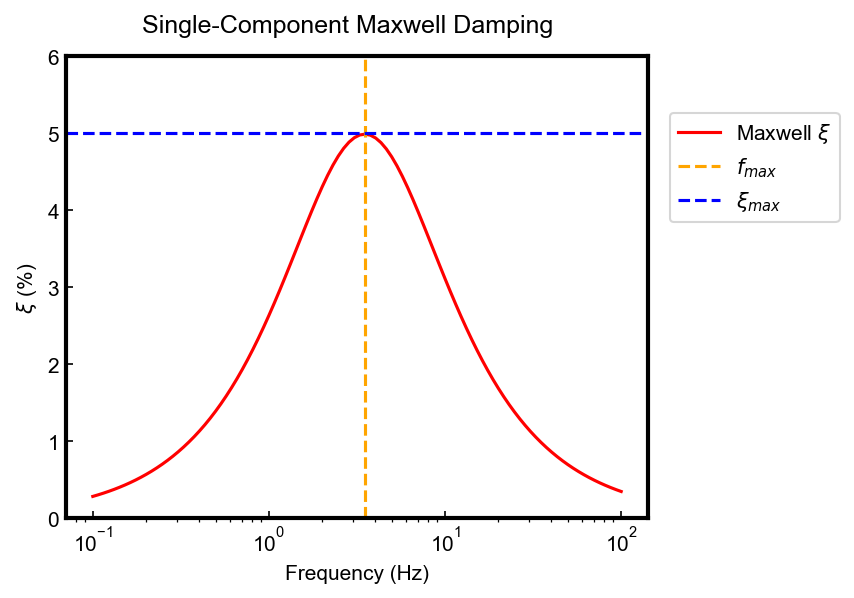

In [62]:
target_damping = 5.0 #-[%]
freq_band = np.logspace(-1, 2, num=100)
f = 3.5
d = 5.0/100.0
damping_maxwell = get_single_maxwell_component(f, d, freq_band)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('Single-Component Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='red',label=r'Maxwell $\xi$')
ax.axvline(x=f, color='orange',ls='--',label='$f_{max}$')
ax.axhline(y=d*100, color='blue',ls='--',label=r'$\xi_{max}$')
ax.set_ylim(0, 6)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left')

### `FLAC` Inputs 

In [66]:
fd1 = 0.039
f1 = 0.5
fd2 = 0.029
f2 = 3.5
fd3 = 0.039
f3 = 25.0
target_damping = 5.0

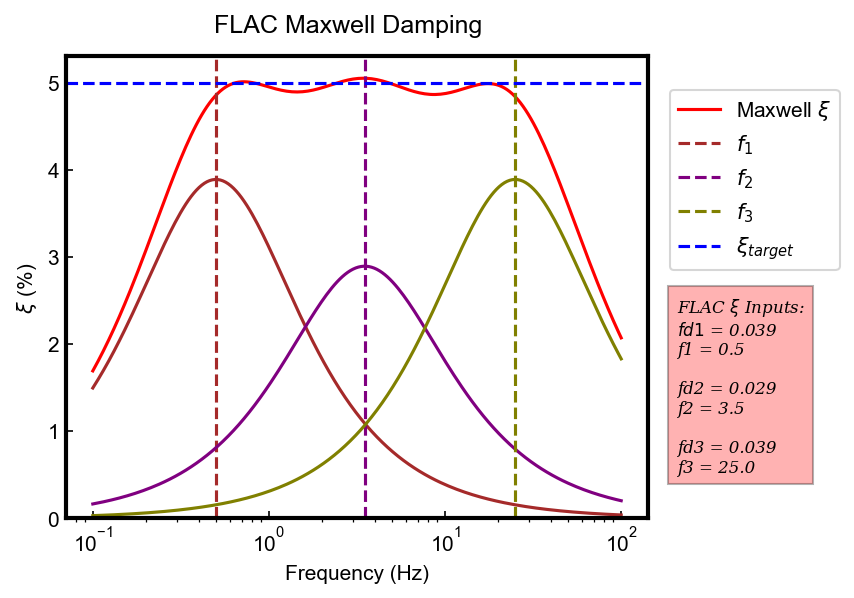

In [75]:
fd_all= [fd1, fd2, fd3]
f_all = [f1, f2, f3]

color_list = ['brown', 'purple', 'olive']
damping_maxwell, freq_band = get_flac_maxwell(fd1, f1, fd2, f2, fd3, f3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('FLAC Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='red',label=r'Maxwell $\xi$')

for index, (freq, fd) in enumerate(zip(f_all, fd_all)):
        xi_maxwell = get_single_maxwell_component(freq, fd, freq_band)
        ax.semilogx(freq_band, xi_maxwell, color=color_list[index])
        ax.axvline(x=freq, label=f'$f_{index+1}$', color=color_list[index], ls='--')

ax.axhline(y=target_damping, color='blue',ls='--',label=r'$\xi_{target}$')

ax.set_ylim(0, None)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left')
t = str(r"FLAC $\xi$ Inputs:" +
    f"\n$fd1$ = {fd1}\nf1 = {f1}" +
    f'\n ' +
    f"\nfd2 = {fd2}\nf2 = {f2}" +
    f'\n '
    f"\nfd3 = {fd3}\nf3 = {f3}")

ax.text(1.05, 0.1, t, bbox=dict(facecolor='red', alpha=0.3), transform=ax.transAxes, family='serif', style='italic',size=8)
plt.show()
plt.close()